# Installing libraries

In [3]:
!pip install tensorflow==2.18.0 opencv-python matplotlib

# Importing Libraries

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten
import tensorflow as tf

In [3]:
POS_PATH=os.path.join('data','positive')
NEG_PATH=os.path.join('data','negative')
ANC_PATH=os.path.join('data','anchor')

## Creating Directory

In [8]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [9]:
!tar -xf lfw.tgz

for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

# Collecting Positive and anchor classes

In [4]:
import uuid

In [7]:
# establish a connection to webcam
cap=cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame=cap.read()
    frame=frame[50:50+250,250:250+250,:]
    #Anchor collection
    if cv2.waitKey(1) & 0XFF==ord('a'):
        imgname=os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    #Positive collections
    if cv2.waitKey(1) & 0XFF==ord('p'):
        imgname=os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    cv2.imshow('Image Collection',frame)
    #breaking and exiting
    if cv2.waitKey(1) & 0XFF==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [35]:
frame.shape

(480, 640, 3)

# Preprocessing

## Getting Image Directories

In [59]:
anchor=tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive=tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative=tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [12]:
dir_test=anchor.as_numpy_iterator()

In [13]:
dir_test.next()

b'data\\anchor\\72d9840b-aa1e-11ef-bda4-00d49ebba21e.jpg'

## Scale and Resize

In [4]:
def preprocess(file_path):
    byte_img=tf.io.read_file(file_path)
    img=tf.io.decode_jpeg(byte_img)
    img=tf.image.resize(img,(100,100))
    img=img/255.0
    return img

In [61]:
img=preprocess('data\\anchor\\72d9840b-aa1e-11ef-bda4-00d49ebba21e.jpg')

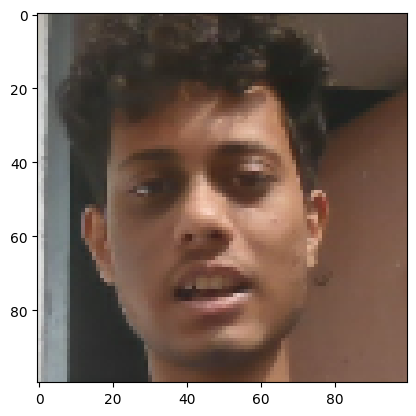

In [62]:
plt.imshow(img)

## Create labelled Dataset

In [63]:
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data=positives.concatenate(negatives)

In [17]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [18]:
samples=data.as_numpy_iterator()

In [19]:
samples.next()

(b'data\\anchor\\721b6cba-aa1e-11ef-97e3-00d49ebba21e.jpg',
 b'data\\positive\\9c8ef6a6-aa1e-11ef-8191-00d49ebba21e.jpg',
 np.float32(1.0))

## Build Train and Test Partition

In [5]:
def preprocess_twin(input_img,validation_img,label):
    return (preprocess(input_img),preprocess(validation_img),label)

In [21]:
preprocess_twin(*samples.next())

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.75392157, 0.7382353 , 0.7029412 ],
         [0.7414216 , 0.7296569 , 0.6963235 ],
         [0.660049  , 0.65710783, 0.62671566],
         ...,
         [0.36666667, 0.30294117, 0.27058825],
         [0.35980392, 0.30490196, 0.26960784],
         [0.35686275, 0.3019608 , 0.26666668]],
 
        [[0.7595588 , 0.74191177, 0.717402  ],
         [0.75      , 0.7382353 , 0.7107843 ],
         [0.6666667 , 0.6637255 , 0.6333333 ],
         ...,
         [0.35686275, 0.3019608 , 0.2647059 ],
         [0.35588235, 0.3009804 , 0.2637255 ],
         [0.35588235, 0.3009804 , 0.2637255 ]],
 
        [[0.7610294 , 0.7492647 , 0.72181374],
         [0.7531863 , 0.7436274 , 0.71544117],
         [0.6767157 , 0.6737745 , 0.6492647 ],
         ...,
         [0.35661766, 0.30171567, 0.25857842],
         [0.3529412 , 0.29803923, 0.25490198],
         [0.3529412 , 0.29803923, 0.25490198]],
 
        ...,
 
        [[0.8034314 , 0.8220588 

In [65]:
data=data.map(preprocess_twin)
data=data.cache()
data=data.shuffle(buffer_size=1024)

In [23]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [66]:
train_data=data.take(round(len(data)*0.7))
train_data=train_data.batch(16)
train_data=train_data.prefetch(8)

In [25]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [67]:
test_data=data.skip(round(len(data)*0.7))
test_data=test_data.take(round(len(data)*0.3))
test_data=test_data.batch(16)
test_data=test_data.prefetch(8)

# Model Engineering

## Build an Embedding Layer

In [68]:
def make_embedding():
    inp=Input (shape=(100,100,3),name='input_image')
    #First Block
    c1=Conv2D(64,(10,10),activation='relu')(inp)
    m1=MaxPooling2D(64,(2,2),padding='same')(c1)

    #Second Block
    c2=Conv2D(128,(7,7),activation='relu')(m1)
    m2=MaxPooling2D(64,(2,2),padding='same')(c2)

    #Third Block
    c3=Conv2D(128,(4,4),activation='relu')(m2)
    m3=MaxPooling2D(64,(2,2),padding='same')(c3)

    #Final Embedding block
    c4=Conv2D(256,(4,4),activation='relu')(m3)
    f1=Flatten()(c4)
    d1=Dense(4096,activation='sigmoid')(f1)
    return Model(inputs=[inp],outputs=d1,name='embedding')

In [69]:
embedding=make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## Build Distance Layer

In [6]:
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()
        
    def call(self,input_embedding,validation_embedding):
        # print(input_embedding);
        # print(type(input_embedding))
        # a=tf.convert_to_tensor(input_embedding);
        # # a=tf.reshape(a,[-1]);
        # print(a)
        # b=tf.convert_to_tensor(validation_embedding);
        # b=tf.reshape(b,[-1]);
        result= tf.math.abs(input_embedding-validation_embedding)
        print(result)
        return result

In [71]:
l1=L1Dist()
l1

<L1Dist name=l1_dist_2, built=False>

## Make Siamese Model

In [72]:
def make_siamese_model():
    input_image=Input(name='input_img',shape=(100,100,3))
    validation_image=Input(name='validation_img',shape=(100,100,3))
    siamese_layer=L1Dist()
    siamese_layer._name='distance'
    distances=siamese_layer(embedding(input_image),embedding(validation_image))
    classifier=Dense(1,activation='sigmoid')(distances)
    return Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwork')
    

In [89]:
siamese_model=make_siamese_model()
siamese_model.summary()

Tensor("Abs:0", shape=(None, 4096), dtype=float32)


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_4 (L1Dist)            │ (None, 4096)              │               0 │ embedding[2][0],           │
│                               │                           │                 │ embedding[3][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_4[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Training

## Setup Loss and Optimizer

In [7]:
binary_cross_loss=tf.losses.BinaryCrossentropy()

In [8]:
opt=tf.keras.optimizers.Adam(1e-4)

In [10]:
checkpoint_dir='./training_checkpoints'
checkpoints_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)

NameError: name 'siamese_model' is not defined

In [ ]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X=batch[:2]
        y=batch[2]
        # y = tf.reshape(y, (-1, 1, 1))
        yhat=siamese_model(X,training=True)
        # yhat = tf.reshape(yhat, [-1]) 
        loss=binary_cross_loss(y,yhat)

    grad=tape.gradient(loss,siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    return loss

In [11]:
@tf.function
def validation_step(batch):
    X=batch[:2]
    y=batch[2]
    yhat = siamese_model(X, training=False)
    loss = binary_cross_loss(y, yhat)
    return loss

In [12]:
def train(data,validation_data,EPOCHS,patience=10):
    best_val_loss = float('inf')  # Initialize the best validation loss to infinity
    patience_counter = 0
    best_epoch = 0
    best_weights = None
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar=tf.keras.utils.Progbar(len(data))
        epoch_loss = 0.0
        for idx,batch in enumerate(data):
            batch_loss = train_step(batch)
            epoch_loss += batch_loss.numpy()
            progbar.update(idx + 1, [("loss", batch_loss)])
            
        # Calculate average training loss for the epoch
        avg_epoch_loss = epoch_loss / len(data)
        print(f"Average training loss for epoch {epoch}: {avg_epoch_loss:.4f}")
        # Validation Phase
        val_loss = 0.0
        for val_batch in validation_data:
            val_loss += validation_step(val_batch).numpy()
        avg_val_loss = val_loss / len(validation_data)
        print(f"Validation loss for epoch {epoch}: {avg_val_loss:.4f}")
        # Early Stopping Check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_epoch = epoch
            best_weights = siamese_model.get_weights()  # Save the best weights
        else:
            patience_counter += 1
        
        # Stop if no improvement after `patience` epochs
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}. Best epoch: {best_epoch} with validation loss: {best_val_loss:.4f}")
            siamese_model.set_weights(best_weights)  # Restore best weights
            break
        if epoch%10==0 or epoch == best_epoch:
            checkpoint.save(file_prefix=checkpoints_prefix)

In [96]:
EPOCH = 50

## Training of Model

In [97]:
train(train_data,test_data,EPOCH)


 Epoch 1/50
Tensor("SiameseNetwork_1/l1_dist_4_1/Abs:0", shape=(16, 4096), dtype=float32)
Tensor("SiameseNetwork_1/l1_dist_4_1/Abs:0", shape=(16, 4096), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - loss: 0.2212Tensor("SiameseNetwork_1/l1_dist_4_1/Abs:0", shape=(4, 4096), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step - loss: 0.2157
Average training loss for epoch 1: 0.2157
Tensor("SiameseNetwork_1/l1_dist_4_1/Abs:0", shape=(16, 4096), dtype=float32)
Tensor("SiameseNetwork_1/l1_dist_4_1/Abs:0", shape=(4, 4096), dtype=float32)
Validation loss for epoch 1: 0.1046

 Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - loss: 0.0923
Average training loss for epoch 2: 0.0923
Validation loss for epoch 2: 0.0869

 Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - loss: 0.0958
Average training loss for epoch 3: 0.0958
Validation loss for epoch 3: 0.0685

 Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - loss: 0.0788
Average training loss for epoch 4: 0.0788
Validation l

# RESULT

In [98]:
from tensorflow.keras.metrics import Precision, Recall

In [99]:
test_input,test_val,y_true=test_data.as_numpy_iterator().next() 

In [100]:
y_hat=siamese_model.predict([test_input,test_val])
y_hat

Tensor("SiameseNetwork_1/l1_dist_4_1/Abs:0", shape=(16, 4096), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[1.0000000e+00],
       [4.7765866e-07],
       [3.5594251e-06],
       [9.9999976e-01],
       [5.6162271e-08],
       [9.9938375e-01],
       [9.9982142e-01],
       [1.0000000e+00],
       [1.2165481e-07],
       [3.2221212e-08],
       [4.5443528e-08],
       [3.8664166e-07],
       [1.0452736e-06],
       [9.9975407e-01],
       [9.9999982e-01],
       [5.9068532e-07]], dtype=float32)

In [102]:
[1 if prediction>0.5 else 0 for prediction in y_hat]

[1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0]

In [103]:
y_true

array([1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.],
      dtype=float32)

In [104]:
m=Precision()
m.update_state(y_true,y_hat)
m.result().numpy()

np.float32(1.0)

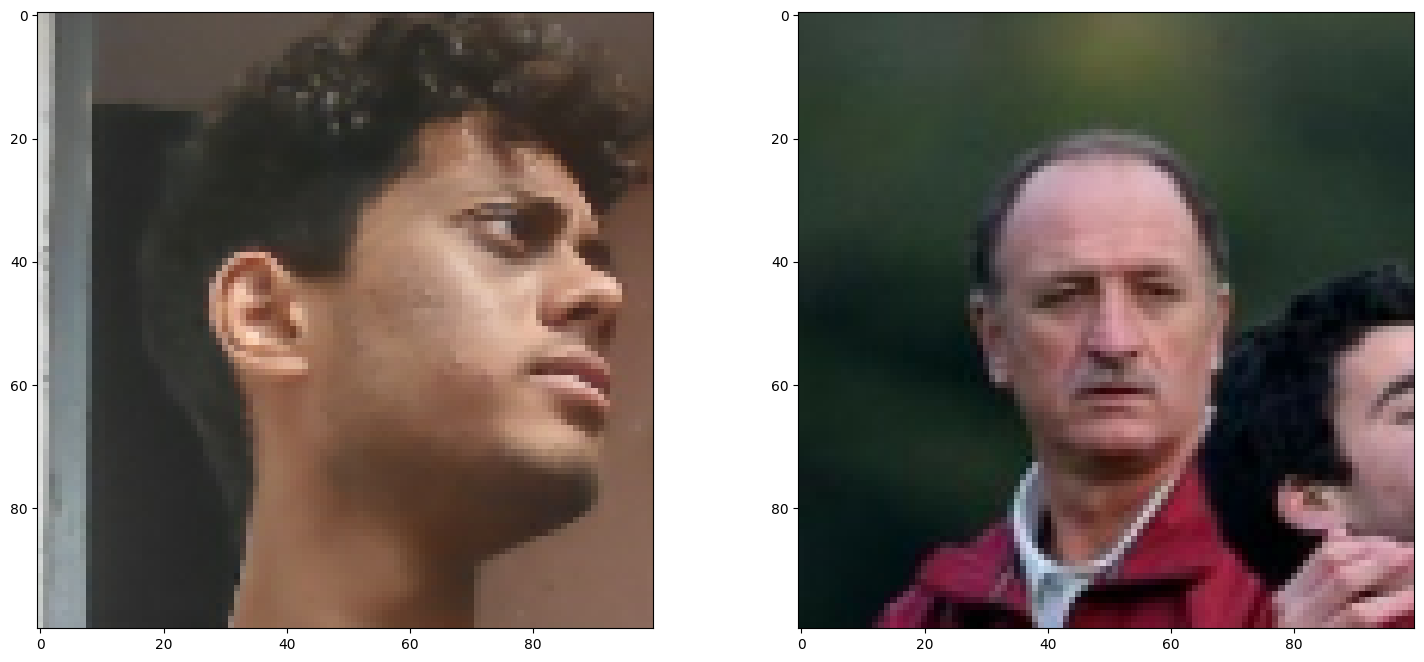

In [107]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[1])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()

# Save Model

In [108]:
siamese_model.save('siamesemodel1.h5')

# Loading Model

In [9]:
model=tf.keras.models.load_model('siamesemodel1.h5',custom_objects={'L1Dist':L1Dist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})


Tensor("Abs:0", shape=(None, 4096), dtype=float32)


# Real Time Test

## Verification Function

In [ ]:
def verify(model,detection_threshold,verification_threshold):
    results=[]
    for image in os.listdir(os.path.join('Application_Data','Verification__Images')):
        input_img=preprocess(os.path.join('Application_Data','Input_image','input_image.jpg'))
        validation_img=preprocess(os.path.join('Application_Data','Verification__Images',image))
        result=model.predict(list(np.expand_dims([input_img,validation_img],axis=1)))
        if result<detection_threshold:
            print(image)
        results.append(result)
    detection=np.sum(np.array(results)>detection_threshold)
    verification=detection/len(os.listdir(os.path.join('Application_Data','Verification__Images')))
    verified=verification>verification_threshold
    # print(detection)
    # print(verification)
    return results,verified

## OpenCV Real Time Verification

In [ ]:
cap=cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame=cap.read()
    frame=frame[50:50+250,250:250+250,:]
    cv2.imshow('Verification',frame)
    if cv2.waitKey(10) & 0xFF==ord('v'):
        #save input image to input image folder
        cv2.imwrite(os.path.join('Application_Data','Input_image','input_image.jpg'),frame)
        # verification function
        results,verified=verify(model,0.9,0.5)
        print(verified)
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
460f70ed-aa1f-11ef-ad2c-00d49ebba21e.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
469b95d6-aa1f-11ef-af8d-00d49ebba21e.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
4abaa0b1-aa1f-11ef-8fc2-00d49ebba21e.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
4ac76d4b-aa1f-11ef-b0dd-00d49ebba21e.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
4b3364f4-aa1f-11ef-a888-00d49ebba21e.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
8214b857-aa1d-11ef-a0ba-00d49ebba21e.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
11
0.6470588235294118
True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 